In [46]:
import numpy as np
import pandas as pd
import cvxpy as cp 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import true_positive_rate
from fairlearn.reductions import DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import math
import scipy.stats as stats
import models as md
import datasets as ds
import utils as ut 
import seaborn as sns

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Synthetic Data

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

n = 1000
d = 2
x = np.random.randn(n, d) 

g1 = np.sqrt(0.3)*x[:, 1] + np.sqrt(0.8)*x[:, 0] + 0.01*np.random.randn(n) 
g2 = -np.sqrt(0.01)*x[:, 0] + np.sqrt(0.9)*x[:, 1] + 0.01*np.random.randn(n)
g3 = np.sqrt(0.15)*x[:, 0] + np.sqrt(0.85)*x[:, 1] + 0.01*np.random.randn(n)
g = np.sqrt(0.7)*x[:, 1] + np.sqrt(0.3)*x[:, 0]
b = np.asarray([9, 1])
y = sigmoid(x@b) + 0.1*np.random.randn(n)# should be between 0 and 1

In [3]:
data_df = pd.DataFrame() 
data_df['x1'] = x[:, 0]
data_df['x2'] = x[:, 1]
data_df['g1_c'] = g1
data_df['g2_c'] = g2
data_df['g3_c'] = g3
data_df['g_c'] = g
data_df['g1'] = (g1 > 0).astype(int)
data_df['g2'] = (g2 > 0).astype(int)
data_df['g3'] = (g3 > 0).astype(int)
data_df['g'] = (g > 0).astype(int)
data_df['y_c'] = y
data_df['y'] = (y > 0.5).astype(int)

In [4]:
# Original Covariance
for group in ['g1_c', 'g2_c', 'g3_c']: 
    print(f'cov(y, {group}) : {ut.emp_cov(data_df["y"], data_df[group]):.2f} '
          f'var({group}): {np.var(data_df[group]):.2f}, '
          f'corr(y, {group}) {stats.pearsonr(data_df["y"], data_df[group])[0]:.2f} ')
    print(f'cov(g, {group}) : {ut.emp_cov(data_df["g"], data_df[group]):.2f} '
          f'var({group}): {np.var(data_df[group]):.2f}, '
          f'corr(g, {group}) {stats.pearsonr(data_df["g"], data_df[group])[0]:.2f} ')
print(f'cov(g, y) {ut.emp_cov(data_df["g"], data_df["y"]):.2f}')
print(f'corr(g, y) {stats.pearsonr(data_df["g"], data_df["y"])[0]:.2f} ')
print(f'var(y) {np.var(data_df["y"])}')
print(f'var(g) {np.var(data_df["g_c"])}')

cov(y, g1_c) : 0.37 var(g1_c): 1.08, corr(y, g1_c) 0.71 
cov(g, g1_c) : 0.38 var(g1_c): 1.08, corr(g, g1_c) 0.74 
cov(y, g2_c) : -0.01 var(g2_c): 0.94, corr(y, g2_c) -0.01 
cov(g, g2_c) : 0.30 var(g2_c): 0.94, corr(g, g2_c) 0.62 
cov(y, g3_c) : 0.18 var(g3_c): 1.02, corr(y, g3_c) 0.36 
cov(g, g3_c) : 0.40 var(g3_c): 1.02, corr(g, g3_c) 0.79 
cov(g, y) 0.11
corr(g, y) 0.42 
var(y) 0.24985600000000005
var(g) 1.012151721186346


In [5]:
frac = 0.7
train_ind = np.random.choice([True, False], size=len(data_df), p=[frac, 1-frac])
data_df['train'] = train_ind

x_train = data_df[data_df['train']==True][['x1', 'x2']].values
y_train = data_df[data_df['train']==True]['y'].values
x_test = data_df[data_df['train']==False][['x1', 'x2']].values
y_test = data_df[data_df['train']==False]['y'].values
g1_train = data_df[data_df['train']==True]['g1'].values
g1_test = data_df[data_df['train']==False]['g1'].values
g_train = data_df[data_df['train']==True]['g'].values
g_test = data_df[data_df['train']==False]['g'].values

In [13]:
models = {}
clf = LogisticRegression()
clf.fit(x_train, y_train)

pg_clf = LogisticRegression() 
pg_clf.fit(x_train, g1_train)
# add pg data for plotting
data_df['pg1'] = pg_clf.predict_proba(data_df[['x1', 'x2']].values)[:, 1]

pg2_clf = LogisticRegression() 
pg2_clf.fit(x_train, g2[train_ind]>0)
data_df['pg2'] = pg2_clf.predict_proba(data_df[['x1', 'x2']].values)[:, 1]


results = ut.results_summary(clf=clf, 
                            pg1=pg_clf, 
                            pg2=pg2_clf, 
                            x=x_test, 
                            y=y_test, 
                            g=g_test)

models['Base'] = {'acc': results['accuracy'], 
                  'coeff':clf.coef_[0], 
                  'intercept':clf.intercept_}

print(results)

{'accuracy': 0.9863013698630136, 'cov(p, pg1)': 0.14670730857880254, 'cov(p, pg2)': -0.011871913662357857, 'DP': 0.3701149425287356}


In [48]:
dp = DemographicParity(difference_bound=0.01)
dp.load_data(x_train, y_train, sensitive_features=g_train)


/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/jhs/opt/anaconda3/envs/ml/lib/python3.10

NameError: name 'y_pred' is not defined

In [14]:
# DP Continuous Discrete Attributes
postprocess_est = ThresholdOptimizer(
    estimator=clf, 
    constraints="demographic_parity", 
    objective='accuracy_score', 
    predict_method="predict", 
    flip =True
)

postprocess_est.fit(X=x_train, y=y_train, sensitive_features=g_train)

p_train = postprocess_est.predict(x_train, sensitive_features=g_train)

p_clf = LogisticRegression()
p_clf.fit(x_train, p_train)

results = ut.results_summary(clf=p_clf, 
                            pg1=pg_clf, 
                            pg2=pg2_clf, 
                            x=x_test, 
                            y=y_test, 
                            g=g_test)

models['DP wrt G'] = {'acc': results['accuracy'], 
                      'coeff': p_clf.coef_[0], 
                      'intercept':p_clf.intercept_}

print(results)

{'accuracy': 0.6541095890410958, 'cov(p, pg1)': 0.03839071904454429, 'cov(p, pg2)': -0.04385409629419538, 'DP': 0.0019704433497536034}


In [44]:
for name, g_clf in zip(['DP wrt Pg1', 'DP wrt Pg2'], [pg_clf, pg2_clf]): 
    c_post_processed = md.MACov(base_clf=clf, pg_clf=g_clf)
    md.fit_pg_cont(p_x=x_train, 
                   base_clf=c_post_processed, 
                   pg_clf=g_clf, 
                   alpha=1e-4)
    p = c_post_processed.predict_proba_1d(x_train)

    p_clf = LogisticRegression()
    p_clf.fit(x_train, p>0.5)
    results = ut.results_summary(clf=c_post_processed, 
                            pg1=pg_clf, 
                            pg2=pg2_clf, 
                            x=x_test, 
                            y=y_test, 
                            g=g_test)
    print(name, results)
    
    
    models[name] = {'acc': results['accuracy'], 
                    'coeff': p_clf.coef_[0], 
                    'intercept':p_clf.intercept_}

0 0.15426939690790822 0.0001
1 0.12457386708633335 0.0001
2 0.10152519206086384 0.0001
3 0.08317992367008577 0.0001
4 0.06828161834223419 0.0001
5 0.05620445832389491 0.0001
6 0.04635333292835636 0.0001
7 0.03833309040945343 0.0001
8 0.03171114630353812 0.0001
9 0.026237455258098313 0.0001
10 0.021735343204665986 0.0001
11 0.01805667918540769 0.0001
12 0.015027599755063063 0.0001
13 0.012523857148539189 0.0001
14 0.010466958731386932 0.0001
15 0.008751118767843492 0.0001
16 0.007321815288897165 0.0001
17 0.006128776570164119 0.0001
18 0.005137654206955221 0.0001
19 0.004309177511310222 0.0001
20 0.003614488621621169 0.0001
21 0.003034197932108818 0.0001
22 0.00254905957167388 0.0001
23 0.0021416132266272765 0.0001
24 0.0018006470072796162 0.0001
25 0.0015146387907565605 0.0001
26 0.0012746386430050353 0.0001
27 0.0010726674109740565 0.0001
28 0.0009026992715779782 0.0001
29 0.0007596632158027944 0.0001
30 0.0006392917548665529 0.0001
31 0.0005379935994511173 0.0001
32 0.000452746513383

In [39]:
c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=[pg_clf, pg2_clf])
md.fit_dp_pg_multi(x=x_train,  
                   multi_clf=c_post_processed, 
                   alpha=1e-5, 
                  max_iter=30)

p = c_post_processed.predict_proba_1d(x_train)


p_clf = LogisticRegression()
p_clf.fit(x_train, p>0.5)
results = ut.results_summary(clf=c_post_processed, 
                        pg1=pg_clf, 
                        pg2=pg2_clf, 
                        x=x_test, 
                        y=y_test, 
                        g=g_test)
print(name, results)

1e-05 0 0.15426939690790822 0.1975607840383415 0.7746236452240541
1e-05 1 -0.0050038036852629334 0.15041517055407713 -0.028807140145481514
1e-05 0 0.12498250573419564 0.1503701733777132 0.7193325548325706
1e-05 1 -0.010964374424219544 0.117352265546172 -0.07146342420862839
1e-05 0 0.10273560383031338 0.1171362164506017 0.669941251530854
1e-05 1 -0.014297069058882306 0.0943111278497668 -0.1039468298239216
1e-05 0 0.08521557388726035 0.0939437789303603 0.6205064476172075
1e-05 1 -0.016101315312660888 0.07813339799494352 -0.12861413521281856
1e-05 0 0.07102369240835765 0.07766748218615264 0.5687808579378212
1e-05 1 -0.01682372022758971 0.06657615747235468 -0.14558223343787266
1e-05 0 0.059474164649400404 0.0660674960375981 0.5164113341482518
1e-05 1 -0.016841238760802173 0.058229241022518204 -0.15582931848670614
1e-05 0 0.05000200336825541 0.05771951969831628 0.4645017870296831
1e-05 1 -0.016424800265782715 0.05216702499719421 -0.16056384696812975
1e-05 0 0.04216977385271428 0.05168220008

[7.54658841 0.77441367] [-0.01205086]
[ 1.48475678 -0.53156056] [1.36238814]
[7.54658841 0.77441367] [-0.01205086]
[ 0.5474636  -1.72686748] [-3.39296224]
[7.54658841 0.77441367] [-0.01205086]
[5.75942187 0.45087639] [-0.27483197]


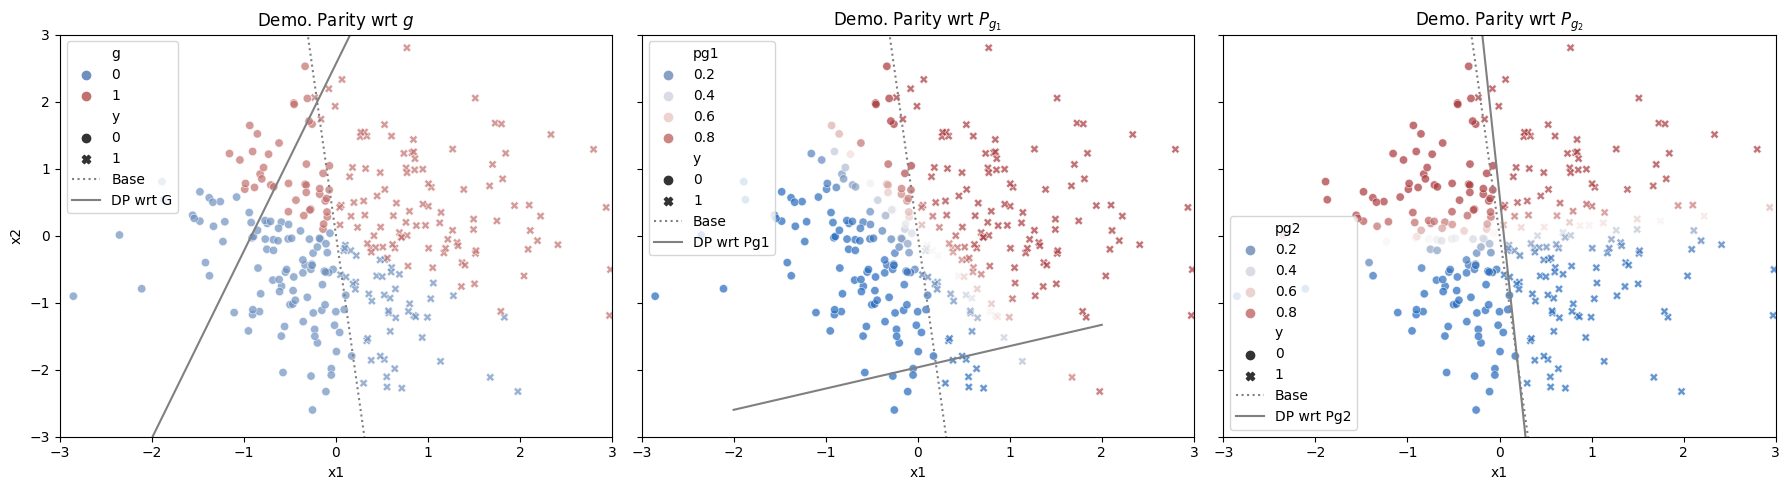

In [26]:
c1 = sns.color_palette("vlag")[0]
c2 = sns.color_palette("vlag")[-1]
custom_palette = [c1, c2]

fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(18, 5)) 
plot_df = data_df[data_df['train']==False]
sns.scatterplot(data=plot_df, x='x1', y='x2', 
                hue='g', style='y', alpha=0.7, ax=axes[0], palette=custom_palette)

# demographic parity - two groups
for key, l in zip(['Base', 'DP wrt G'], [':', '-']): 
    coef = models[key]['coeff']
    intercept = models[key]['intercept']
    print(coef, intercept)
    xx = np.linspace(-2, 2, 100)
    yy = (-intercept - coef[0] * xx) / coef[1]
    acc = models[key]['acc']
    axes[0].plot(xx, yy, c='gray', linestyle=l, label=f"{key}")
    axes[0].legend()
axes[0].set_title(r"Demo. Parity wrt $g$")

sns.scatterplot(data=plot_df, x='x1', y='x2', 
                hue='pg1', style='y', alpha=0.7, ax=axes[1], palette='vlag')
for key, l in zip(['Base', 'DP wrt Pg1'], [':', '-']): 
    coef = models[key]['coeff']
    intercept = models[key]['intercept']
    print(coef, intercept)
    xx = np.linspace(-2, 2, 100)
    yy = (-intercept - coef[0] * xx) / coef[1]
    acc = models[key]['acc']
    axes[1].plot(xx, yy, c='gray', linestyle=l, label=f"{key}")
    axes[1].legend()
axes[1].set_title(r"Demo. Parity wrt $P_{g_1}$")


sns.scatterplot(data=plot_df, x='x1', y='x2', 
                hue='pg2', style='y', alpha=0.7, ax=axes[2], palette='vlag')
for key, l in zip(['Base', 'DP wrt Pg2'], [':', '-']): 
    coef = models[key]['coeff']
    intercept = models[key]['intercept']
    print(coef, intercept)
    xx = np.linspace(-2, 2, 100)
    yy = (-intercept - coef[0] * xx) / coef[1]
    acc = models[key]['acc']
    axes[2].plot(xx, yy, c='gray', linestyle=l, label=f"{key}")
    axes[2].legend()
    axes[2].set_xlim(-3, 3)
    axes[2].set_ylim(-3, 3)
    
axes[2].set_title(r"Demo. Parity wrt $P_{g_2}$")
fig.tight_layout() 
fig.savefig("synthetic_dp.pdf")

In [ ]:
# Multi Accuracy
g_clf = pg1_clf
pg = g_clf.predict_proba(x_train)[:, 1]
cov = ut.emp_cov(pg, y_train)
p = clf.predict(x_train)
curr_cov = ut.emp_cov(pg, p)
print(f"baseline cov {cov}, curr cov: {curr_cov}")

c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=[g_clf])
md.fit_ma_pg_multi(x=x_train, 
                   multi_clf=c_post_processed, 
                   cov_ypg=cov, 
                   alpha=1e-5)

p = c_post_processed.predict_proba_1d(x_test)
p_acc = accuracy_score(y_test, p>0.5)

new_cov_d = ut.emp_cov(p>0.5, g_clf.predict_proba(x_test)[:, 1])
new_cov_c = ut.emp_cov(p, g_clf.predict_proba(x_test)[:, 1])

print(f"clf acc: {p_acc:.3f} new_cov_c: {new_cov_d:.3f}")

# p_clf = LogisticRegression()
# p_clf.fit(x_test, p>0.5)
# models[name] = {'acc': p_acc, 'coeff': p_clf.coef_[0], 'intercept':p_clf.intercept_}


In [ ]:
# Equal Opportunity
eo_clf = md.EOClf(base_clf=clf, pg_clf=pg1_clf)
eo_clf.fit(x=x_train, y=y_train>0.5)

In [ ]:
p = clf.predict_proba(x_train)[:, 1]
pg = pg1_clf.predict_proba(x_train)[:, 1]

eo_clf.check_bins(y_train, p, pg, 2*0.3, 2*0.36)

In [ ]:
p = clf.predict_proba(x_train)[:, 1]
pg = pg1_clf.predict_proba(x_train)[:, 1]
print(ut.eo_metric(y_pred=p, y_true=y_train, pg=pg))
p = eo_clf.predict_proba_1d(x_train)
print(ut.eo_metric(y_pred=p, y_true=y_train, pg=pg))

In [ ]:
# more complicated data

N = 400
theta = np.sqrt(np.random.rand(N))*2*math.pi # np.linspace(0,2*pi,100)

r_a = 2*theta + math.pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - math.pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.show()